
## Web Service Classification using BERT (RoBERTa)

In [6]:
!pip install transformers datasets seaborn accelerate

## 1.  Load Python Modules

In [7]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from transformers import (
    RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
)
import warnings
import torch
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
%matplotlib inline

sns.set(style="whitegrid")
os.makedirs("charts", exist_ok=True)
os.makedirs("results", exist_ok=True)
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 2. Model -Helper-functions

In [8]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average='weighted', zero_division=0),
        "recall": recall_score(labels, preds, average='weighted', zero_division=0),
        "f1": f1_score(labels, preds, average='weighted', zero_division=0)
    }

def tokenize_function(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

def plot_confusion_and_report(y_true, y_pred, class_names, n):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - Top {n} Categories")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"charts/bert_confusion_matrix_top_{n}.png")
    plt.show()

    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)
    print(f"classification_report for {n} Web Serivce Categories")
    print(classification_report(y_true, y_pred, target_names=class_names))
    return report



## 3. Train and Evaluate

In [9]:
def train_and_evaluate(n):
    df = pd.read_csv(f"../data/Balanced_Top_{n}_Web_Services.csv").dropna()
    df = df[['Service Description', 'Grouped Category']].rename(columns={'Service Description': 'text', 'Grouped Category': 'label'})

    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
    num_labels = df['label'].nunique()
    class_names = label_encoder.classes_

    dataset = Dataset.from_pandas(df.reset_index(drop=True))
    dataset = dataset.train_test_split(test_size=0.2, seed=42)
    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    tokenized_dataset = tokenized_dataset.remove_columns(["text"])

    model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=num_labels)
    training_args = TrainingArguments(
        output_dir=f"./results_top_{n}",
        num_train_epochs=10,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        logging_dir=f"./logs_top_{n}"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset['train'],
        eval_dataset=tokenized_dataset['test'],
        tokenizer=tokenizer
        #compute_metrics=compute_metrics
    )

    trainer.train()
    preds = trainer.predict(tokenized_dataset['test'])
    y_true = preds.label_ids
    y_pred = np.argmax(preds.predictions, axis=1)

    metrics = compute_metrics((preds.predictions, y_true))

    report = plot_confusion_and_report(y_true, y_pred, class_names, n)

    return {
        "model": "RoBERTa",
        "accuracy": metrics["accuracy"],
        "precision": metrics["precision"],
        "recall": metrics["recall"],
        "f1_score": metrics["f1"]
    }


## 4. Run the Model


 Processing Top 50 Web Service Categories


Map:   0%|          | 0/7995 [00:00<?, ? examples/s]

Map:   0%|          | 0/1999 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,2.531100
1000,1.495200
1500,1.121400
2000,1.037300
2500,0.737100
3000,0.688100
3500,0.476800
4000,0.502000
4500,0.308800
5000,0.347000


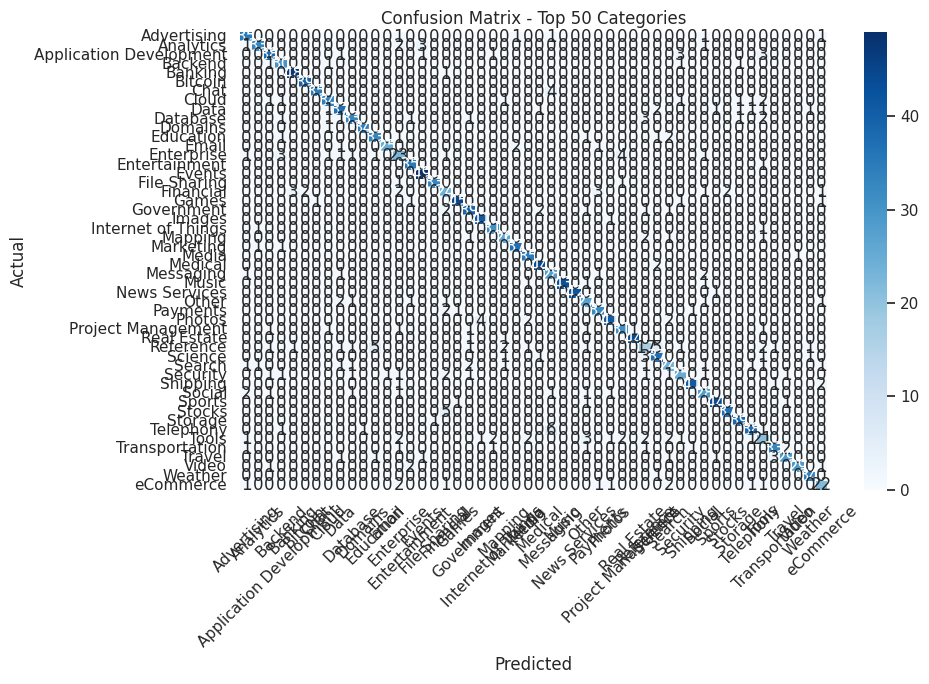

classification_report for 50 Web Serivce Categories
                         precision    recall  f1-score   support

            Advertising       0.80      0.88      0.83        40
              Analytics       0.92      0.82      0.87        40
Application Development       0.84      0.81      0.83        47
                Backend       0.77      0.88      0.82        34
                Banking       0.92      0.98      0.95        49
                Bitcoin       0.95      1.00      0.97        39
                   Chat       0.97      0.90      0.93        39
                  Cloud       0.85      0.81      0.83        42
                   Data       0.79      0.80      0.80        46
               Database       0.85      0.75      0.80        44
                Domains       0.97      0.97      0.97        35
              Education       0.82      0.85      0.84        39
                  Email       0.96      0.86      0.91        29
             Enterprise       0.59   

In [10]:
# Run and collect results
bert_results = []
for n in [50]:
    print(f"\n Processing Top {n} Web Service Categories")
    bert_results.append(train_and_evaluate(n))

# Save results
with open("results/bert_roberta_results.pkl", "wb") as f:
    pickle.dump(bert_results, f)

## 5. Performance and Plots

In [11]:
# Plot metrics
print(bert_results)

[{'model': 'RoBERTa', 'accuracy': 0.8514257128564282, 'precision': 0.8520610596924839, 'recall': 0.8514257128564282, 'f1_score': 0.8503794329692775}]
